# Demo the Arbitrageur Agent Logic

This notebook:

1. Fetches the latest crvusd contract data into Python objects using `crvusdsim`.
2. Fetches prices and `ExternalMarket`s from the `baseline` scenario.
3. Instantiates an Arbitrageur agent.
4. Checks if there are profitable arbitrages and performs them.

In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from crvusdsim.pool import get
from src.agents import Arbitrageur
from src.sim.scenario import Scenario
from src.utils.poolgraph import PoolGraph
from src.configs import SYMBOL_TO_ADDRESS
from src.configs.tokens import *
from src.modules import ExternalMarket


%load_ext autoreload
%autoreload 2

In [2]:
ETH_POOL = "weth"
sim_market = get(ETH_POOL, bands_data="controller")
pool = sim_market.pool
stableswap_pools = sim_market.stableswap_pools

In [3]:
# Generate markets and prices
scenario = Scenario("baseline")
sample = scenario.pricepaths[0]
scenario.update_market_prices(sample)
markets = scenario.markets
arbitrageur = scenario.arbitrageur

[DEBUG][23:24:44][root]-640919: Using 502560 1Inch quotes.


In [4]:
# Create a list of all stableswap pools, LLAMMAs, and External Markets.
markets_lst = list(markets.values())
pools = stableswap_pools + [pool] + markets_lst
print(
    f"There are {len(pools)} total pools:\nStableSwap: {len(stableswap_pools)}\nLLAMMA: 1\nExternal Markets: {len(markets_lst)}"
)

There are 20 total pools:
StableSwap: 4
LLAMMA: 1
External Markets: 15


In [5]:
n = 3
graph = PoolGraph(pools)
cycles = graph.find_cycles(n=n)
cycles

[INFO][23:24:47][root]-640919: Found 20 valid cycles of length 3.


[Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=Curve.Fi USD Stablecoin (crvUSD), amt=0), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDP, in=Curve.Fi USD Stablecoin (crvUSD), out=USDP, amt=0), Swap(pool=External Market (TUSD, USDP), in=Pax Dollar, out=TrueUSD, amt=0)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=Curve.Fi USD Stablecoin (crvUSD), amt=0), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=Curve.Fi USD Stablecoin (crvUSD), out=USDC, amt=0), Swap(pool=External Market (TUSD, USDC), in=USD Coin, out=TrueUSD, amt=0)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=Curve.Fi USD Stablecoin (crvUSD), amt=0), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDT, in=Curve.Fi USD Stablecoin (crvUSD), out=USDT, amt=0), Swap(pool=External Market (TUSD, USDT), in=Tether USD, out=TrueUSD, amt=0)], Expected Profit: None),
 Cycle(Tr

In [6]:
df = pd.DataFrame(
    columns=["amt_optimize", "amt_linspace", "profit_optimize", "profit_linspace"]
)

for i, cycle in enumerate(cycles):
    try:
        # This is orders of magnitude slower than `optimize`
        trade = cycle.trades[0]
        high = trade.pool.get_max_trade_size(trade.i, trade.j)
        amts = np.linspace(0, high, 1000)
        amts = [int(amt) for amt in amts]
        profits = [cycle.populate(amt) for amt in amts]

        best_amt_linspace = int(amts[np.argmax(profits)])
        best_profit_linspace = int(max(profits))

        cycle.optimize()

        df.loc[i] = [
            cycle.trades[0].amt,
            best_amt_linspace,
            cycle.expected_profit,
            best_profit_linspace,
        ]

    except Exception as e:
        logging.error(f"Cycle {i} failed to optimize: {e}")

df["profit_linspace"] = df["profit_linspace"].astype(float)
df["profit_optimize"] = df["profit_optimize"].astype(float)
df = df.round(3)
df

,amt_optimize,amt_linspace,profit_optimize,profit_linspace
0,270.0,0.0,-0.000,0.0
1,162272825268369.0,0.0,-0.000,0.0
2,1396316747991162.0,0.0,-0.000,0.0
3,890825266519157396996096,891507075925464653496320,17628.414,17628.0
4,15034786457510142279680,14060937876192918241280,0.864,0.0
5,1057084680153532.0,0.0,-0.000,0.0
6,53201668521967013068800,52728517035723444977664,7.698,7.0
7,643007357801572826349568,622196501021536680935424,14185.538,14180.0
8,499686959.0,0.0,0.226,0.0
9,2345.0,0.0,-0.000,0.0


Best amount linspace: 14060937876192918241280
Best profit linspace: 0.8599908514413936
Best amount optimize: 15034786457510142279680
Best profit optimize: 0.8635990684865659


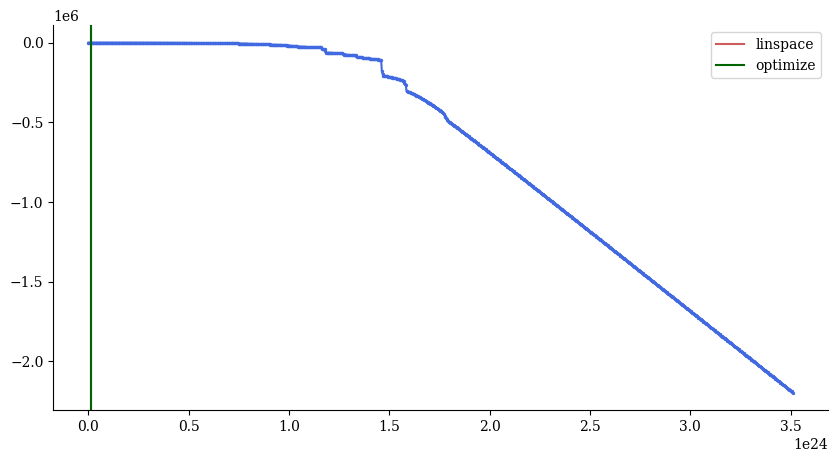

In [7]:
# TODO this curve is probably not smooth because:
# 1. The decimals are not being treated correctly between trades <- fixed
# 2. The state of each pool is not being snapshot correctly (i.e. it's changing) <- ??
# 3. I think it's because External Market slippage is noisy. <- fixed

i = 4
cycle = cycles[i]

trade = cycle.trades[0]
high = trade.pool.get_max_trade_size(trade.i, trade.j)
amts = np.linspace(1, high, 1000)
amts = [int(amt) for amt in amts]
profits = [cycle.populate(amt) for amt in amts]

best_amt_linspace = amts[np.argmax(profits)]
best_profit_linspace = max(profits)

# compare
cycle.optimize()
best_amt_optimize = cycle.trades[0].amt
best_profit_optimize = cycle.expected_profit

f, ax = plt.subplots(figsize=(10, 5))
ax.scatter(amts, profits, color="royalblue", s=2)
ax.plot(amts, profits, color="royalblue")
ax.axvline(best_amt_linspace, color="indianred", label="linspace")
ax.axvline(best_amt_optimize, color="darkgreen", label="optimize")

# NOTE Uncomment to zoom into optimal region
# diff = abs(best_amt_optimize - best_amt_linspace)
# xlims = (float(min(best_amt_optimize, best_amt_linspace) - diff), float(max(best_amt_optimize, best_amt_linspace) + diff))
# tmp = [p for p, a in zip(profits, amts) if xlims[0] < a < xlims[1]]
# ylims = min(tmp), max(tmp)
# ax.set_xlim(*xlims)
# ax.set_ylim(*ylims)

ax.legend()

print(f"Best amount linspace: {best_amt_linspace}")
print(f"Best profit linspace: {best_profit_linspace}")
print(f"Best amount optimize: {best_amt_optimize}")
print(f"Best profit optimize: {best_profit_optimize}")

# Analyzing arbitrages

In [8]:
def test():
    best = arbitrageur.find_best_arbitrage(cycles)

    # get the trades in the cycle
    # the price of pool 1 * price of pool 2 should approach pool 3
    def get_prices(cycle):
        prices = []
        for trade in best.trades:
            price = trade.pool.price(trade.i, trade.j)
            if not isinstance(trade.pool, ExternalMarket):
                price /= 1e18
            prices.append(price)
        return prices

    prices = get_prices(best)

    print(f"Pre Trade prices: {prices}")
    print(f"External Market price: {prices[2]}")
    print(f"Curve pool prices: {prices[0] * prices[1]}")
    print()

    best.execute()
    prices = get_prices(best)

    print(f"Post Trade prices: {prices}")
    print(f"External Market price: {prices[2]}")
    print(f"Curve pool prices: {prices[0] * prices[1]}")


# test()

In [9]:
profit, count = arbitrageur.arbitrage(cycles, sample)
profit, count

[INFO][23:24:54][root]-640919: Executing cycle Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=USDC, out=Curve.Fi USD Stablecoin (crvUSD), amt=965966822735), Swap(pool=Curve.fi Stablecoin WETH, in=crvUSD, out=WETH, amt=968080026602500799887617), Swap(pool=External Market (USDC, WETH), in=Wrapped Ether, out=USD Coin, amt=473397304021554306178)], Expected Profit: 20533.992357).
[INFO][23:24:54][root]-640919: Executing trade Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=USDC, out=Curve.Fi USD Stablecoin (crvUSD), amt=965966822735).
[INFO][23:24:54][root]-640919: Executing trade Swap(pool=Curve.fi Stablecoin WETH, in=crvUSD, out=WETH, amt=968080026602500799887617).
[INFO][23:24:54][root]-640919: Executing trade Swap(pool=External Market (USDC, WETH), in=Wrapped Ether, out=USD Coin, amt=473397304021554306178).
[INFO][23:24:55][root]-640919: Executing cycle Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=USDC, out=Curve.Fi USD Stablecoin (

(20549.03581271338, 4)